Block 1 — imports & paths

In [10]:
import os, h5py, numpy as np, matplotlib.pyplot as plt
from collections import defaultdict

DATA_ROOT = "../data/brain-to-text-25/t15_copyTask_neuralData/hdf5_data_final"
SPLIT = "data_train.hdf5"  # change to data_val.hdf5 / data_test.hdf5 as needed


Block 2 — list available days & pick one example day

In [11]:
days = sorted([d for d in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT, d))])
print("Days found:", len(days))
print(days[:10], "...")
EXAMPLE_DAY = days[0] if days else None
print("Example day:", EXAMPLE_DAY)


Days found: 45
['t15.2023.08.11', 't15.2023.08.13', 't15.2023.08.18', 't15.2023.08.20', 't15.2023.08.25', 't15.2023.08.27', 't15.2023.09.01', 't15.2023.09.03', 't15.2023.09.24', 't15.2023.09.29'] ...
Example day: t15.2023.08.11


Block 3 — helper to scan one file (lengths, labels, feature dim)


In [12]:
def scan_hdf5(file_path):
    lengths = []
    label_nonzero = []
    label_pad_frac = []
    feat_dim = None
    n_trials = 0

    with h5py.File(file_path, "r") as f:
        for tkey in sorted(f.keys()):
            g = f[tkey]
            if "input_features" not in g:
                continue
            X = g["input_features"]
            n_trials += 1
            lengths.append(int(X.shape[0]))
            if feat_dim is None and X.ndim >= 2:
                feat_dim = int(X.shape[1])
            if "seq_class_ids" in g:
                y = g["seq_class_ids"][()]
                nz = int(np.count_nonzero(y))
                label_nonzero.append(nz)
                if len(y) > 0:
                    label_pad_frac.append((len(y) - nz) / len(y))
    return {
        "n_trials": n_trials,
        "lengths": np.array(lengths, dtype=int),
        "feat_dim": feat_dim,
        "label_nonzero": np.array(label_nonzero, dtype=int),
        "label_pad_frac": np.array(label_pad_frac, dtype=float),
    }


Block 4 — scan all days for one split


In [18]:
import pandas as pd
def scan_hdf5(file_path):
    """Scan one HDF5 split file and return trial length + feature stats."""
    try:
        with h5py.File(file_path, "r") as f:
            lengths = []
            feat_dim = None
            n_trials = 0
            for tkey in sorted(f.keys()):
                g = f[tkey]
                feats = g["input_features"][()]
                lengths.append(feats.shape[0])   # number of time steps
                feat_dim = feats.shape[1]        # number of channels
                n_trials += 1

        return {
            "file": file_path,
            "n_trials": n_trials,
            "min_len": min(lengths) if lengths else None,
            "max_len": max(lengths) if lengths else None,
            "mean_len": np.mean(lengths) if lengths else None,
            "feat_dim": feat_dim,
        }
    except Exception as e:
        print(f"⚠️ Skipping {file_path}: {e}")
        return None


# ---- Loop over all days ----
base_dir = "../data/brain-to-text-25/t15_copyTask_neuralData/hdf5_data_final"
all_stats = []

for day in sorted(os.listdir(base_dir)):
    day_path = os.path.join(base_dir, day)
    train_file = os.path.join(day_path, "data_train.hdf5")

    if os.path.exists(train_file):
        stats = scan_hdf5(train_file)
        if stats:
            all_stats.append(stats)

# ---- Summarize in a DataFrame ----
df_stats = pd.DataFrame(all_stats)
print(df_stats)

# Example: print global averages
if not df_stats.empty:
    print("\nOverall:")
    print("Total trials:", df_stats["n_trials"].sum())
    print("Global mean length:", df_stats["mean_len"].mean())
    print("Feature dimension (should be consistent):", df_stats["feat_dim"].unique())

                                                 file  n_trials  min_len  \
0   ../data/brain-to-text-25/t15_copyTask_neuralDa...       288      138   
1   ../data/brain-to-text-25/t15_copyTask_neuralDa...       348      239   
2   ../data/brain-to-text-25/t15_copyTask_neuralDa...       197      361   
3   ../data/brain-to-text-25/t15_copyTask_neuralDa...       278      378   
4   ../data/brain-to-text-25/t15_copyTask_neuralDa...        88      356   
5   ../data/brain-to-text-25/t15_copyTask_neuralDa...       150      321   
6   ../data/brain-to-text-25/t15_copyTask_neuralDa...       297      324   
7   ../data/brain-to-text-25/t15_copyTask_neuralDa...       322      325   
8   ../data/brain-to-text-25/t15_copyTask_neuralDa...       245      346   
9   ../data/brain-to-text-25/t15_copyTask_neuralDa...       153      328   
10  ../data/brain-to-text-25/t15_copyTask_neuralDa...       218      362   
11  ../data/brain-to-text-25/t15_copyTask_neuralDa...       174      321   
12  ../data/

Block 5 — bar chart: trials per day (imbalance across days)

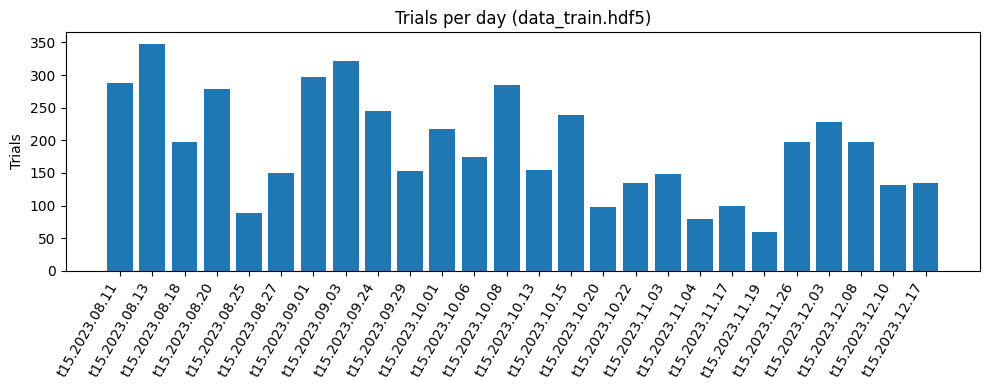

In [19]:
day_names = list(per_day.keys())
trial_counts = [per_day[d]["n_trials"] for d in day_names]

plt.figure(figsize=(10,4))
plt.bar(day_names, trial_counts)
plt.xticks(rotation=60, ha="right")
plt.ylabel("Trials")
plt.title(f"Trials per day ({SPLIT})")
plt.tight_layout()
plt.show()


Block 6 — histogram: trial lengths (variability)

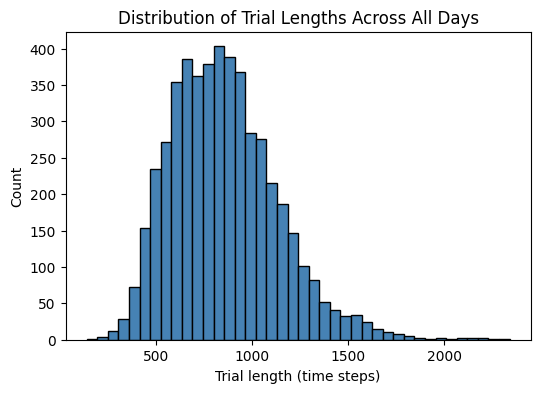

In [22]:
import matplotlib.pyplot as plt

# Flatten list of lists → single flat list of ints
flat_lengths = [l for sublist in total_lengths for l in sublist]

flat_lengths = np.array(flat_lengths)

if flat_lengths.size > 0:
    plt.figure(figsize=(6,4))
    plt.hist(flat_lengths, bins=40, color="steelblue", edgecolor="black")
    plt.xlabel("Trial length (time steps)")
    plt.ylabel("Count")
    plt.title("Distribution of Trial Lengths Across All Days")
    plt.show()



Block 7 — label padding diagnostics


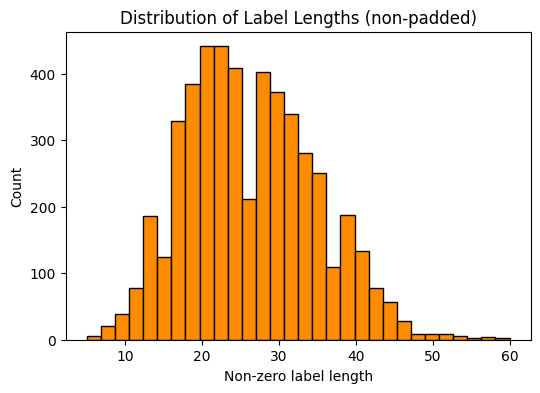

In [24]:
# Flatten list of lists (if it's nested)
flat_label_lengths = [l for sublist in total_label_nonzero for l in sublist] \
    if any(isinstance(el, (list, np.ndarray)) for el in total_label_nonzero) \
    else total_label_nonzero

flat_label_lengths = np.array(flat_label_lengths)

if flat_label_lengths.size > 0:
    plt.figure(figsize=(6,4))
    plt.hist(flat_label_lengths, bins=30, color="darkorange", edgecolor="black")
    plt.xlabel("Non-zero label length")
    plt.ylabel("Count")
    plt.title("Distribution of Label Lengths (non-padded)")
    plt.show()



Block 8 — example trial: one channel timeseries + feature heatmap

Example file: ../data/brain-to-text-25/t15_copyTask_neuralData/hdf5_data_final/t15.2023.08.11/data_train.hdf5
Example trial shape: (321, 512)
Example label (first 50 ids): [ 7 28 17 24 40 17 31 40 20 21 25 29 12 40  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]


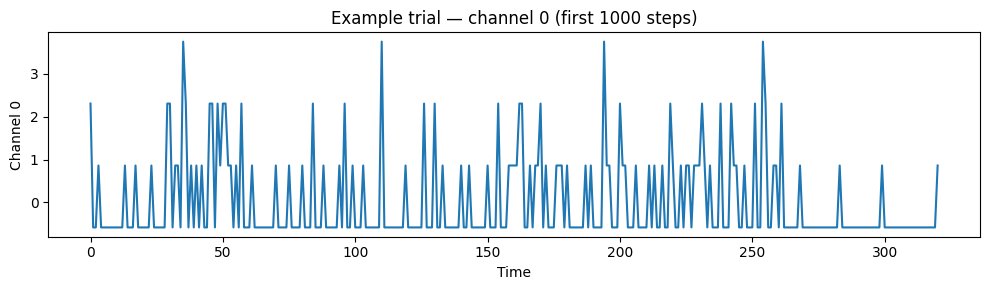

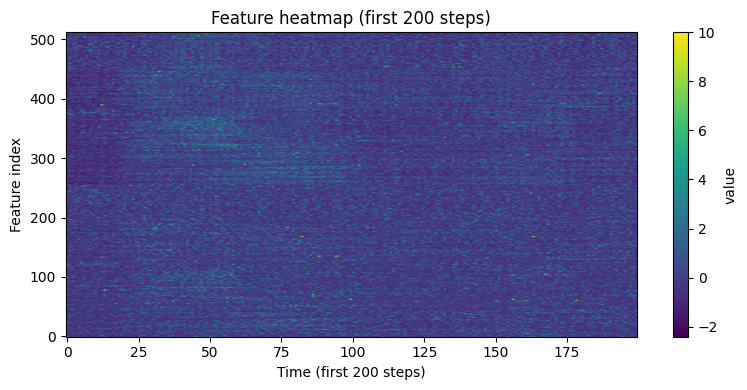

In [31]:
# pick first available file
example_file = None
for d in days:
    fp = os.path.join(DATA_ROOT, d, SPLIT)
    if os.path.exists(fp):
        example_file = fp
        break

print("Example file:", example_file)

with h5py.File(example_file, "r") as f:
    tkey = sorted(f.keys())[0]
    X = f[tkey]["input_features"][()]
    y = f[tkey]["seq_class_ids"][()] if "seq_class_ids" in f[tkey] else np.array([])

print("Example trial shape:", X.shape)
if y.size:
    print("Example label (first 50 ids):", y[:50])

# plot one channel (0) over first 1000 time steps (clip if shorter)
T = min(1000, X.shape[0])
plt.figure(figsize=(10,3))
plt.plot(np.arange(T), X[:T, 0])
plt.xlabel("Time")
plt.ylabel("Channel 0")
plt.title("Example trial — channel 0 (first 1000 steps)")
plt.tight_layout()
plt.show()

# small heatmap (time x features), e.g. first 200 time steps
T_hm = min(200, X.shape[0])
plt.figure(figsize=(8,4))
plt.imshow(X[:T_hm, :].T, aspect="auto", origin="lower")
plt.colorbar(label="value")
plt.xlabel("Time (first 200 steps)")
plt.ylabel("Feature index")
plt.title("Feature heatmap (first 200 steps)")
plt.tight_layout()
plt.show()


Block 9 — quick per-day summary table (printed)

In [26]:
rows = []
for d, s in per_day.items():
    L = s["lengths"]
    nz = s["label_nonzero"]
    pad = s["label_pad_frac"]
    rows.append({
        "day": d,
        "trials": s["n_trials"],
        "len_min": int(L.min()) if L.size else None,
        "len_mean": float(L.mean()) if L.size else None,
        "len_max": int(L.max()) if L.size else None,
        "label_nz_mean": float(nz.mean()) if nz.size else None,
        "pad_frac_mean": float(pad.mean()) if pad.size else None,
    })

# pretty print
for r in rows:
    print(r)


{'day': 't15.2023.08.11', 'trials': 288, 'len_min': 138, 'len_mean': 545.4305555555555, 'len_max': 1025, 'label_nz_mean': 16.583333333333332, 'pad_frac_mean': 0.9668333333333332}
{'day': 't15.2023.08.13', 'trials': 348, 'len_min': 239, 'len_mean': 752.2011494252873, 'len_max': 1427, 'label_nz_mean': 24.75862068965517, 'pad_frac_mean': 0.9504827586206895}
{'day': 't15.2023.08.18', 'trials': 197, 'len_min': 361, 'len_mean': 885.5228426395939, 'len_max': 1629, 'label_nz_mean': 26.80203045685279, 'pad_frac_mean': 0.9463959390862944}
{'day': 't15.2023.08.20', 'trials': 278, 'len_min': 378, 'len_mean': 797.9928057553957, 'len_max': 1735, 'label_nz_mean': 26.399280575539567, 'pad_frac_mean': 0.9472014388489208}
{'day': 't15.2023.08.25', 'trials': 88, 'len_min': 356, 'len_mean': 801.7045454545455, 'len_max': 1330, 'label_nz_mean': 26.375, 'pad_frac_mean': 0.94725}
{'day': 't15.2023.08.27', 'trials': 150, 'len_min': 321, 'len_mean': 849.5133333333333, 'len_max': 1874, 'label_nz_mean': 27.126666